# Introduction to the 2D Heat Equation and PINNs

## The General Heat Equation  
The **heat equation** is a parabolic partial differential equation (PDE) that describes how heat (or temperature) diffuses through a medium over time. The general form for an unsteady, anisotropic, heterogeneous material is:

$$  
\rho c_p \frac{\partial T}{\partial t} = \nabla \cdot (k \nabla T) + Q  
$$  

**Terms**:  
- $T(\mathbf{x}, t)$: Temperature field ($\mathbf{x} = (x, y)$ in 2D)  
- $\rho$: Material density (kg/m³)  
- $c_p$: Specific heat capacity (J/kg·K)  
- $k$: Thermal conductivity tensor (W/m·K)  
- $Q$: Heat source/sink term (W/m³)  

## Simplifying Assumptions  
1. **Isotropic Material**: $k$ is a scalar (same conductivity in all directions).  
2. **Constant Properties**: $\rho$, $c_p$, and $k$ are uniform in space/time.  
3. **2D Cartesian Domain**: No $z$-dependence.  
4. **No Heat Source**: $Q = 0$.  
5. **Steady-State**: $\frac{\partial T}{\partial t} = 0$.  

## Simplified Cartesian Form  
Under these assumptions, the equation reduces to the **Laplace equation**:  

$$  
\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0  
$$  

**Key Notes**:  
- Solution $T(x, y)$ depends only on spatial coordinates.  
- Boundary conditions (Dirichlet/Neumann) are required for uniqueness.  

## Physics-Informed Neural Networks (PINNs)  
We solve this PDE using a **PINN**, which:  
- Embeds the Laplace equation into the neural network’s loss.  
- Uses automatic differentiation to compute derivatives ($\frac{\partial^2 T}{\partial x^2}$, etc.).  
- Avoids traditional mesh-based methods (FEM/FDM).  
- Is computationally more effcient.

**Assumptions Recap**:  
1. Isotropic, homogeneous material.  
2. 2D Cartesian geometry.  
3. No heat sources.  
4. Steady-state conditions.  

# 
---

# Finite Difference Method (FDM) for the 2D Heat Equation

### Step-by-Step FDM Implementation

1. **Domain Discretization**  
   - Divide the square domain into a uniform grid with spacing $( \Delta x , \Delta y  )$.
   - Label nodes as $( (i,j) )$, where $( i = 1, 2, \dots, N_y )$ (rows) and $( j = 1, 2, \dots, N_x )$ (columns).

2. **Discretization of the Laplace Equation**  
   Central difference approximation for second derivatives:
   $$
   \frac{T_{i+1,j} - 2T_{i,j} + T_{i-1,j}}{h^2} + \frac{T_{i,j+1} - 2T_{i,j} + T_{i,j-1}}{h^2} = 0
   $$
   Simplifies to the **5-point stencil**:
   $$
   T_{i,j} = \frac{1}{4} \left( T_{i+1,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} \right)
   $$

3. **Handling Boundary Conditions (Dirichlet)**  
   - For boundary nodes (e.g., $( i=1 )$, $( j=1 )$, etc.), fix $( T_{i,j} = T_{\text{boundary}} )$.
   - Interior nodes follow the discretized equation.

4. **Constructing the System of Equations**  
   - For each interior node, generate one linear equation.
   - This results in a sparse matrix system $( A\mathbf{T} = \mathbf{Y} )$, where:
     - $( A )$: Coefficient matrix (contains weights from the stencil).
     - $( \mathbf{T} )$: Vector of unknown temperatures (interior nodes).
     - $( \mathbf{Y} )$: Right-hand side vector (contributions from boundary conditions).

5. **Building Matrices \( A \) and $( \mathbf{Y} )$**  
   - **Matrix \( A \)**:  
     - Diagonal entries: \( 1 \) (for $ T_{i,j} $).
     - Off-diagonals: \( -0.25 \) for neighboring nodes (up/down/left/right).
     
   - **Vector $( \mathbf{Y} )$**:  
     Populated by moving known boundary terms to the RHS.

6. **Solving the Linear System**  
   The solution is formally:
   $$
   \mathbf{T} = A^{-1} \mathbf{Y}
   $$
   **Solution Methods**:
   - **Direct Methods** (Exact, for small/moderate systems):
     - Matrix inversion ($ A^{-1} $) via LU decomposition (Gaussian elimination).
     - Cholesky decomposition (if  $ A $ is symmetric positive definite).
   - **Iterative Methods** (Efficient for large sparse systems):
     - Jacobi, Gauss-Seidel.
     - Conjugate Gradient (CG) for symmetric matrices.
     - Multigrid methods (accelerated convergence).

7. **Post-Processing**  
   - Reshape $ \mathbf{T} $ back to grid format for visualization.
   - Validate against analytical solutions (if available).

### Key Notes:
   - **Stability**: Central difference scheme is unconditionally stable for Laplace’s equation.

In [1]:
# Import dependencies
from FDM import ThermalBoundaryConditions, Solver, Visualizer

# Define boundary conditions (Example 4.3 from Incropera 5th Ed.)
try:
    conditions = ThermalBoundaryConditions(
        length=1,                           # Domain length (m)
        width=1,                            # Domain width (m)
        dx=0.25,                            # x-axis grid spacing
        dy=0.25,                            # y-axis grid spacing
        T_top=[500, 500, 500],              # Top boundary temperatures (°C)
        T_bottom=[356.99, 339.05, 356.99],  # Bottom boundary temps (°C)
        T_left=[500, 500, 500],             # Left boundary temperatures (°C)
        T_right=[500, 500, 500]             # Right boundary temperatures (°C)
    )
except ValueError as e:
    print(f"Boundary condition error: {e}")

👇🏻This block will measure the performance of the FDM 

In [2]:
%%timeit
# Solve the heat equation
X, A, Y = Solver(conditions)  # Returns solution vector, matrix A, and RHS Y

31.3 μs ± 2.03 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


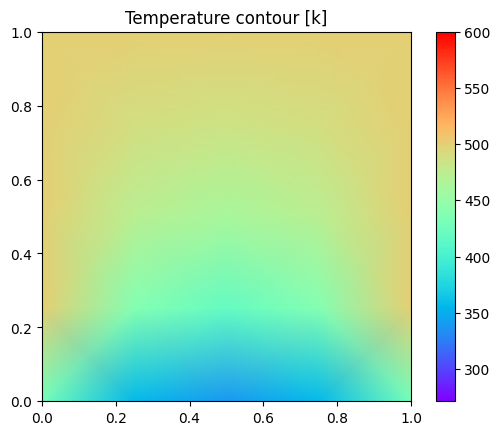

In [3]:
# Solving the heat equation
X, A, Y = Solver(conditions) 
# Visualize results
Visualizer(X, bond_cond=conditions)  # Generate temperature contour plot

### Memory Complexity of `np.linalg.solve()`

When you use `np.linalg.solve(A, b)` to solve a linear system $Ax = b$ for a **dense** matrix $A$ of size $N \times N$:

* **Input Storage:** Storing the $N \times N$ matrix $A$ itself requires $O(N^2)$ memory. The vector $b$ requires $O(N)$ memory.
* **Internal Operations:** `np.linalg.solve` typically performs an **LU decomposition** of $A$. This factorization also requires $O(N^2)$ memory to store the resulting $L$ and $U$ matrices.
* **Overall Complexity:** The dominant memory requirement is for the matrix and its factorization, leading to an overall memory complexity of **$O(N^2)$**.

**For a 2D heat equation** on an $M \times M$ grid, your system matrix $A$ will have dimensions $(M^2) \times (M^2)$, meaning $N = M^2$. Therefore, the memory complexity becomes $O((M^2)^2) = \mathbf{O(M^4)}$. This highlights why direct solvers can be memory-intensive for large 2D or 3D problems; for such cases, **iterative solvers** are often preferred, especially when the matrix is sparse.


# 
----

# Generating Training and Testing data using (FDM)

### Dataset Generation and Preprocessing

For training the **Generalizer Network**, we generate synthetic datasets, which include both a training set and a separate testing (validation) set. These datasets contain crucial information:

* **Boundary Conditions (BCs):** Details about the problem's boundaries.
* **Temperature Distribution on BCs:** The temperature values specified at these boundaries.
* **Temperature Distribution inside the domain:** The temperature at the different nodes.

#### Incorporating Noise for Robustness

To enhance the model's ability to handle real-world complexities, it is highly recommended to introduce a degree of noise into the synthetic data. As highlighted in the paper "Synthetic Data in AI: Challenges, Applications, and Ethical Implications":

> "Insufficient Noise Level. Synthetic datasets may evince an undue sterility, lacking the multifarious noise and intricacies inherent in real-world data. In authentic scenarios, data invariably incorporates diverse interferences, errors, and uncertainties. The paucity of such features within synthetic datasets may hamper the model’s efficacy within realistic environments."

Following this principle, **white Gaussian noise is added exclusively to the training data**, ensuring the model learns to generalize effectively without affecting the pristine evaluation of the testing data.

#### Data Verification

It is crucial to visually inspect a subset of samples from both the training/testing datasets. This manual check ensures that the generated data aligns with expectations and accurately represents the intended problem domain.

### Solver Model Training and Validation

The **Solver Model** operates differently from the Generalizer Network. It does not require explicit target temperature values for its training. Instead, its objective is to learn the underlying physics of the problem directly from defined conditions.

* **Problem Definition for Solver Model:** The solver model primarily requires temperature values at *some* points (not necessarily limited to boundaries) along with their corresponding coordinates.
* **Comparison with FDM:** For a fair and accurate comparison with the Finite Difference Method (FDM) solver, the same boundary conditions used in the FDM approach are provided to the solver model.

#### Validation Strategy Against FDM

For practical validation, a unique strategy is employed due to the computational constraints of the FDM solver:

* **High-Resolution Solver Input:** The solver model is provided with a large number of boundary condition values, simulating a very fine mesh problem.
* **FDM Solver Limitations:** The traditional FDM solver, when attempting to solve this high-resolution problem, often encounters **memory complexity limitations** (as previously discussed, the memory scales as $O(M^4)$ for an $M \times M$ grid).
* **Coarse Mesh for FDM Validation:** To overcome this, a **coarse mesh version** of the problem is defined and solved using the FDM. The results from this coarse FDM solution are then used solely for the **justification and validation** of the Solver Model's output, providing a reliable baseline where FDM is feasible.

In [4]:
#Importing the dependecies
import numpy as np                                  #To handel datasets
from pinnTools import Normalizer, Standardizer      #To preprocess the datasets
from pinnTools import GetDataSet                    #To generate a dataset

### 🟡For the generalizer network

🧪synthesize the training/testing data

In [5]:
#==Training==
num_sim = 100           #Number of simulation
T_min  = -100 + 273 -1  #Minimum possible temperature for boundary condition[k]
T_max = 3300 + 273 -1   #Maximum possible temperature for boundary condition[k]
length = 2              #Length of the domain[m]
width = 2              #Width of the domain[m]
mesh_size=[0.25, 0.25]    #Mesh size (x,y) [m]

#👟Generating the training dataset
result = GetDataSet(
    num_sim, T_min, T_max, length, width, 
    mesh_size[0], mesh_size[1]
)

(bc_top_train, bc_bottom_train, bc_right_train, bc_left_train, mesh_size_train, coordinates_train), (targets_train) = result

#==Testing==
num_sim_test = 200             #Number of simulation
T_min_test  = -100 + 273 -1  #Minimum possible temperature for boundary condition[k]
T_max_test = 3300 + 273 -1   #Maximum possible temperature for boundary condition[k]
length_test = 2              #Length of the domain[m]
width_test = 2               #Width of the domain[m]
mesh_size_test=[.25, .25]   #Mesh size (x,y) [m]

#👟Generating the testing dataset
result_test = GetDataSet(
    num_sim_test, T_min_test, T_max_test, length_test, width_test, 
    mesh_size_test[0], mesh_size_test[1]
)

(bc_top_test, bc_bottom_test, bc_right_test, bc_left_test, mesh_size_test, coordinates_test), (targets_test) = result_test


#### 🖨️Plotting an instance of the dataset and compare it with the solver result for the same boundary condition.

Plotting the GetDataSet results to insure the accuracy of the data generate for the training

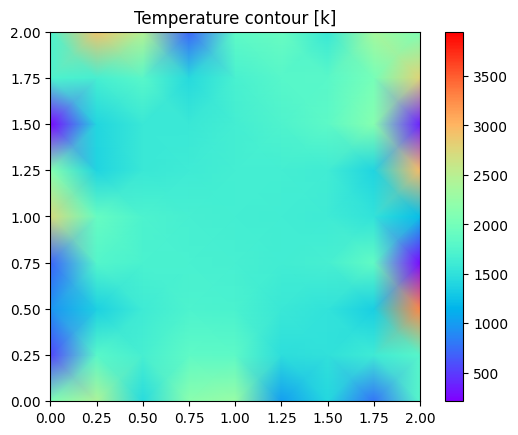

In [6]:
# Define boundary conditions 
try:
    conditions_test_data = ThermalBoundaryConditions(
        length=length,                         # Domain length (m)
        width=width,                           # Domain width (m)
        dx=mesh_size[0],                       # x-axis grid spacing
        dy=mesh_size[1],                       # y-axis grid spacing
        T_top=bc_top_test[0],                # Top boundary temperatures (°C)
        T_bottom=bc_bottom_test[0],          # Bottom boundary temps (°C)
        T_left=bc_left_test[0],              # Left boundary temperatures (°C)
        T_right=bc_right_test[0]              # Right boundary temperatures (°C)
    )
except ValueError as e:
    print(f"Boundary condition error: {e}")

Visualizer(targets_test[0:49], bond_cond=conditions_test_data)  

Plotting the Solver results to compare it with the GetData function results.

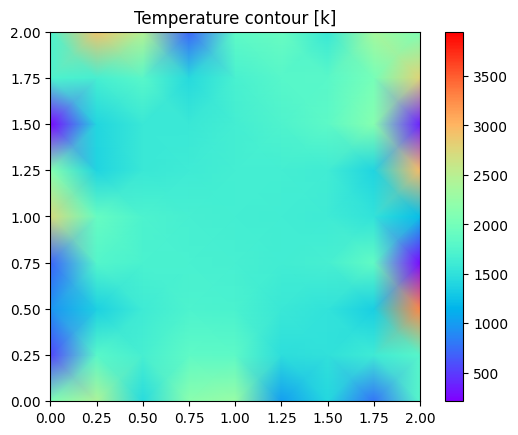

In [7]:
# Solving the heat equation
X, A, Y = Solver(conditions_test_data) 
# Visualize results
Visualizer(X, bond_cond=conditions_test_data)  # Generate temperature contour plot

#### Preprocesssing the datasets


Adding noise to the training data

In [8]:
#Organizing the input data
x_training = [bc_top_train, bc_bottom_train, bc_right_train, bc_left_train, coordinates_train]
y_training = targets_train.copy()

#Organizing the testing data
x_testing = [bc_top_test, bc_bottom_test, bc_right_test, bc_left_test, coordinates_test]
y_testing = targets_test.copy()

#Adding noise to the training targets for better genralization
y_training += np.random.normal(loc=0, scale=10, size=np.array(y_training).shape)

#Visualizing the training data with and without the noise to justify the noise is not to strong
print(f"Sample of training targets without noise:\n {targets_train[0:10]}")
print(f"\n ----------------------------\n")
print(f"Sample of training targets with noise:\n {y_training[0:10]}")

Sample of training targets without noise:
 [2500.29249699 1733.78375766 1499.1078673  1059.0202853  1020.51472855
 1292.23981375 1891.44194984 2510.58984356 1922.18357993 1603.43028269]

 ----------------------------

Sample of training targets with noise:
 [2524.55527166 1721.16194159 1494.91431948 1068.81239092 1020.67517926
 1285.63679499 1902.81786953 2516.09053443 1920.78294093 1603.22300928]


In [9]:
#==Normalizing the input data==
x_training, y_training = Normalizer(x_training, y_training, T_min, T_max, length, width)
x_testing, y_testing = Normalizer(x_testing, y_testing, T_min, T_max, length, width)

# #==Standardizing the input data==
# x_training, stat = Normalizer(training_x=x_training)

# #Applying the normalization to the testing data
# bc_top_test = (bc_top_test - stat['bc_top']['std'])/stat['bc_top']['avg']
# bc_bottom_test = (bc_bottom_test - stat['bc_bottom']['std'])/stat['bc_bottom']['avg']
# bc_right_test = (bc_right_test - stat['bc_right']['std'])/stat['bc_right']['avg']
# bc_left_test = (bc_left_test - stat['bc_left']['std'])/stat['bc_left']['avg']

### 🟣For the solver network

Defining the actual problem

In [10]:
# Import dependencies
from FDM import ThermalBoundaryConditions, Solver, Visualizer

# Define boundary conditions 
try:
    conditions = ThermalBoundaryConditions(
        length=60,                           # Domain length (m)
        width=60,                            # Domain width (m)
        dx=0.25,                            # x-axis grid spacing
        dy=0.25,                            # y-axis grid spacing
        T_top= 239 *[500],              # Top boundary temperatures (°C)
        T_bottom= 239 * [400],  # Bottom boundary temps (°C)
        T_left= 239 *[100],             # Left boundary temperatures (°C)
        T_right= 239 *[700]             # Right boundary temperatures (°C)
    )
except ValueError as e:
    print(f"Boundary condition error: {e}")


⚠️The above problem is not solvable using the FDM code due to high memory complexity.

In [11]:
# # Solving the heat equation (With the exact mesh size)
# X, A, Y = Solver(conditions) 
# # Visualize results
# Visualizer(X, bond_cond=conditions)  # Generate temperature contour plot

Solving the simplified problem for validation

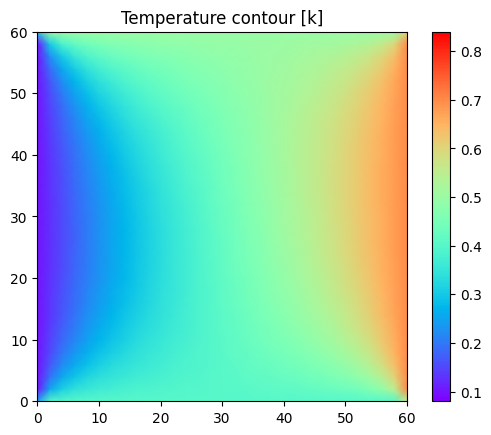

In [12]:
#==Approximate solution for validation==
# Import dependencies
from FDM import ThermalBoundaryConditions, Solver, Visualizer
from pinnTools import ValidationDataOrganizer

# Define boundary conditions (Example 4.3 from Incropera 5th Ed.)
try:
    conditions_apx = ThermalBoundaryConditions(
        length=60,                           # Domain length (m)
        width=60,                            # Domain width (m)
        dx=2,                                # x-axis grid spacing
        dy=2,                               # y-axis grid spacing
        T_top= 29 *[0.500],                   # Top boundary temperatures (°C)
        T_bottom= 29 * [0.400],               # Bottom boundary temps (°C)
        T_left= 29 *[0.100],             # Left boundary temperatures (°C)
        T_right= 29 *[0.700]             # Right boundary temperatures (°C)
    )
except ValueError as e:
    print(f"Boundary condition error: {e}")

# Solving the heat equation
X, A, Y = Solver(conditions_apx) 

#Generating the validation dataset
validation_data = list(ValidationDataOrganizer(X, conditions_apx))
# Visualize results
Visualizer(X, bond_cond=conditions_apx)  # Generate temperature contour plot

#### Normalizing the temperatures

In [13]:
#==Standardizing the boundary conditions data==
T_max_solver = np.max([*conditions.T_top, *conditions.T_bottom, *conditions.T_right, *conditions.T_left])
T_min_solver = np.min([*conditions.T_top, *conditions.T_bottom, *conditions.T_right, *conditions.T_left])


(conditions.T_top, conditions.T_bottom, conditions.T_right, conditions.T_left, _), _ = Normalizer([conditions.T_top, 
              conditions.T_bottom, 
              conditions.T_right,
              conditions.T_left, 
              np.zeros([4,4])],      #Is not important       
              np.zeros([4,4]),          #Is not important       
              T_min = T_min_solver,
              T_max = T_max_solver,
              length = conditions.length,
              width = conditions.width
              )

#==Standardizing the valdiation set==
validation_data[2] = (validation_data[2] - T_min_solver)/(T_max_solver - T_min_solver)


#

---

## The Solver model desgin

The Physics-Informed Neural Network (PINN) in this project is built upon a standard feedforward architecture, comprising:

* **Input Layer:**
    * **X:** Distance from the left boundary in meters (shape: `(None, 1)`)
    * **Y:** Distance from the bottom boundary in meters (shape: `(None, 1)`)

* **Hidden Layers:**
    * 10 fully-connected layers, each with 128 units.
    * **Activation Function:** Tanh ($\tanh(x)$).

* **Output Layer:**
    * A single neuron with a linear activation function.
    * Predicts temperature values (shape: `(None, 1)`).

* **Weight Initialization:**
    * For reproducibility and consistent experimental results, a **fixed random seed** is used during the initialization of the network's weights and biases.


### Activation Function Selection and Considerations

The choice of activation function is paramount for PINNs, especially when solving Partial Differential Equations (PDEs) like the Laplace or Poisson equations, where second derivatives of the solution are central to the governing physics.

#### Key Characteristics Required for PINN Activation Functions:

1.  **Non-Zero Second Derivatives:**
    For PDEs involving second-order derivatives (e.g., $\nabla^2 T$), the activation function must possess non-zero second derivatives across its domain. This is critical for the network to accurately represent and minimize the physics-informed loss (residual of the PDE). Many popular activation functions, such as ReLU and Leaky ReLU, have zero second derivatives almost everywhere, making them unsuitable for such problems.

    * **Sine ($\sin(x)$):**
        $$ \frac{d^2}{dx^2}\sin(x) = -\sin(x) \neq 0 $$
        (Non-zero second derivative)

    * **ReLU ($\max(0,x)$):**
        $$ \frac{d^2}{dx^2}\text{ReLU}(x) = 0 \quad \forall x $$

    * **Leaky ReLU ($\max(\alpha x,x)$):**
        $$ \frac{d^2}{dx^2}\text{LeakyReLU}(x) = 0 \quad \forall x $$

    * **Tanh ($\tanh(x)$):**
        $$ \frac{d^2}{dx^2}\tanh(x) = -2\tanh(x)(1-\tanh^2(x)) $$
        While mathematically non-zero, this derivative approaches zero very rapidly for large absolute values of $x$. This can lead to the "vanishing gradients" problem, where the physical loss of the network approaches zero prematurely, hindering effective training. However, when data is appropriately scaled (normalized/standardized), $\tanh(x)$ can be successfully employed, as seen in this project and established literature (e.g., Raissi et al., 2017 [1]).

    * **Sigmoid ($\sigma(x)$):**
        $$ \frac{d^2}{dx^2}\sigma(x) = \sigma(x)(1-\sigma(x))(1-2\sigma(x))) $$
        Similar to Tanh, its second derivative also approaches zero for values far from the origin.

2.  **Sufficiently Large Second Derivatives in a Relevant Domain:**
    Beyond simply being non-zero, the second derivatives should be sufficiently large within the typical range of neuron activations. Data normalization or standardization can help ensure that activation values fall into regions where the second derivative is significant, thus opening up more viable activation function options.

#### Explored Activation Functions and Observations:

* **Sine Activation:**
    * **Periodic Inductive Bias:** The oscillatory nature of $\sin(x)$ offers a natural periodic inductive bias, which is theoretically beneficial for capturing harmonic solutions common in PDEs like Laplace's equation ($\nabla^2T=0$). Some sources, such as [2], recommend its use for PINNs.
    * **Implementation Note:** Sine activation is not natively supported in Keras and requires custom implementation.
    * **Observed Failure Mode:** In this project, using sine activation led to an "averaging failure mode," where the model consistently predicted a nearly constant temperature value across the entire domain. This issue, where PINNs can converge to trivial solutions, is also discussed in [3], Section 3.1.

* **Specialized Activation Functions:**
    * Research suggests specialized activation functions, such as the L-series activation functions presented in [4], can enhance PINN performance.
    * **Implementation Constraint:** Due to the unavailability of readily accessible software implementations, these functions were not explored in this project.

* **General Purpose Activation Functions (with Data Scaling):**
    * When input and output data are properly normalized or standardized, common activation functions like **Swish** and **Tanh** become viable and can perform effectively for PINN applications. Tanh was successfully utilized in this project, aligning with practices in foundational PINN literature like [1].


### Data Scaling for Network Performance

Neural networks often perform better when input and output values are small. To achieve this, two common data scaling techniques were explored:

1.  **Min-Max Normalization:** Rescales data to a fixed range, typically between 0 and 1. For a given data point $x$, the normalized value $x_{\text{norm}}$ is calculated as:
    $$ x_{\text{norm}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}} $$
    where $x_{\text{min}}$ and $x_{\text{max}}$ are the minimum and maximum values of the feature in the dataset, respectively.

2.  **Standardization (Z-score Normalization):** Scales data to have a mean of 0 and a standard deviation of 1. For a given data point $x$, the standardized value $x_{\text{std}}$ is calculated as:
    $$ x_{\text{std}} = \frac{x - \mu}{\sigma} $$
    where $\mu$ is the mean of the feature and $\sigma$ is its standard deviation.

Both methods were implemented and tested, with **First option demonstrating superior performance** in this project.


### Implementation of the PINN

The core distinction between a PINN and a conventional neural network lies in the inclusion of a **physical loss term** within its overall loss function. This necessitates the development of a custom loss function.

#### Approaches to Loss Function Implementation:

1.  **Full-Batch Training (as in [1]):**
    * This approach involves providing the entire dataset to the model at once for each optimization step, calculating the loss, and then performing the optimization.
    * **Pros:**
        * Simpler implementation, often allowing the direct use of high-level API functions like Keras's `.fit()` method (e.g., see [5]).
    * **Cons:**
        * Inherits all the drawbacks of full-batch training, notably **high memory usage** (especially for large datasets) and **lower data efficiency**.

2.  **Implementing the Training Loop from Scratch (Mini-Batch Training):**
    * This approach allows for the use of mini-batches, where a subset of the data is used for each optimization step.
    * **Pros:**
        * Offers all the advantages of mini-batch optimization, including **better memory efficiency** and **improved data efficiency**.
        * Provides **greater flexibility** in defining custom training logic.
    * **Cons:**
        * Requires writing more custom code for the training step (and loop).

In this project, we opted for the **second approach (mini-batch training)** due to its advantages in memory and data efficiency, along with increased flexibility.

#### The Training Process

The PINN training process involves a sophisticated loss function designed to enforce both boundary conditions and the underlying physical laws:

1.  **Boundary Condition (BC) Loss:** The model's temperature predictions at the boundary points are compared against the prescribed boundary conditions. The deviation is calculated, contributing to the "BC loss."
2.  **Physical Loss (PDE Residual):**
    * The Laplacian of the predicted temperature, $\nabla^2 T = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}$, is calculated both at the boundary points (where $\nabla^2 T$ should ideally be zero for Laplace's equation) and at randomly selected "collocation points" within the domain.
    * The goal is to minimize this Laplacian value, pushing it towards zero, thus ensuring the solution satisfies the PDE.
3.  **Total Loss Function:** The overall loss for optimization is a weighted sum of these components:
    $$ \text{Overall Loss} = \text{BC Loss} + \lambda \times \text{Physical Loss} $$
    Here, $\lambda$ is a hyperparameter used to balance the relative importance of satisfying the boundary conditions versus the physical laws.
4.  **Optimization:** An optimizer is then used to adjust the network's trainable parameters (weights and biases) to minimize this overall loss function.

To monitor the training progress and evaluate the model's generalization capabilities, the model's performance is regularly assessed against the separate validation/testing dataset, which was generated using the Finite Difference Method (FDM).


### Optimizer

For this project, the **AdamW** and **Adam** optimizers were utilized.

* **Adam (Adaptive Moment Estimation):**
    * Formula for updating weights $w$:
        $$ w_{t+1} = w_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t $$
        where $\eta$ is the learning rate, $\hat{m}_t$ and $\hat{v}_t$ are bias-corrected estimates of the first moment (mean) and second moment (uncentered variance) of the gradients, respectively, and $\epsilon$ is a small constant to prevent division by zero.

* **AdamW (Adam with Weight Decay):):**
    * AdamW separates the weight decay (L2 regularization) term from the adaptive learning rate update. Its update rule for weights $w$ is typically:
        $$ w_{t+1} = w_t - \eta \cdot (\frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} + \lambda_w w_t) $$
        where $\lambda_w$ is the weight decay rate.

Given that no explicit regularization techniques like L1 or L2 regularization or dropout were applied within the network architecture itself, **AdamW was chosen over Adam**. AdamW effectively performs **decoupled weight decay**, which has been shown to be more effective than Adam with standard L2 regularization in improving generalization, as discussed in articles such as [6]. This choice helps prevent overfitting and improves the model's robustness.


In [14]:
#Importing the dependeices(External)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Importing the dependieces(pinnTools)
from pinnTools import TrainSolver, BuildFunc, Solver
from pinnTools import TrainSolver, GenerateTemperatureField

In [46]:
#Building the solver model
model_solver = BuildFunc(num_hidden_layers=10,
                        num_units=128,
                        input_shapes=[
                            1,                          # For the x  [m]  
                            1,                          # For the y  [m]  
                        ]
)


#🗞️Getting the summary of the solver model to make sure the network is built correctly.
model_solver.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 2)         │          0 │ input_layer_7[0]… │
│ (Concatenate)       │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │        384 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 128)       │     16,512 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 128)       │     16,512 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 128)       │     16,512 │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 128)       │     16,512 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 128)       │     16,512 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 128)       │     16,512 │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 128)       │     16,512 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 128)       │     16,512 │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 128)       │     16,512 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 1)         │        129 │ dense_41[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 149,121 (582.50 KB)

 Trainable params: 149,121 (582.50 KB)

 Non-trainable params: 0 (0.00 B)

💪🏻Training the model 

In [47]:
#Setting the model's optimizer 
model_solver.compile(optimizer=tf.keras.optimizers.AdamW())

history = TrainSolver(model_solver, validation_data=validation_data ,training_x=conditions, epochs=70, batch_size=128)

-----------------
Epoch : 1/70
Physical loss: 0.007430229886693476
Boundary loss: 0.5740317106246948
Total loss: 0.6472117900848389
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation loss: 0.5132099986076355
-----------------
Epoch : 2/70
Physical loss: 0.007932872594158943
Boundary loss: 0.30911219120025635
Total loss: 0.3865984380245209
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation loss: 0.7963025569915771
-----------------
Epoch : 3/70
Physical loss: 0.0029616276809881813
Boundary loss: 0.2793999910354614
Total loss: 0.30806300044059753
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation loss: 0.8603940010070801
-----------------
Epoch : 4/70
Physical loss: 0.0014515857144568973
Boundary loss: 0.258219838142395
Total loss: 0.2732645273208618
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation loss: 0.703884482383728
-----------------
Epoch : 5/70
Physical loss: 0.0010254192897257964
Boundary loss: 0.2762416899204254
Total loss: 0.286110520362854
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

📈Plotting the training progress

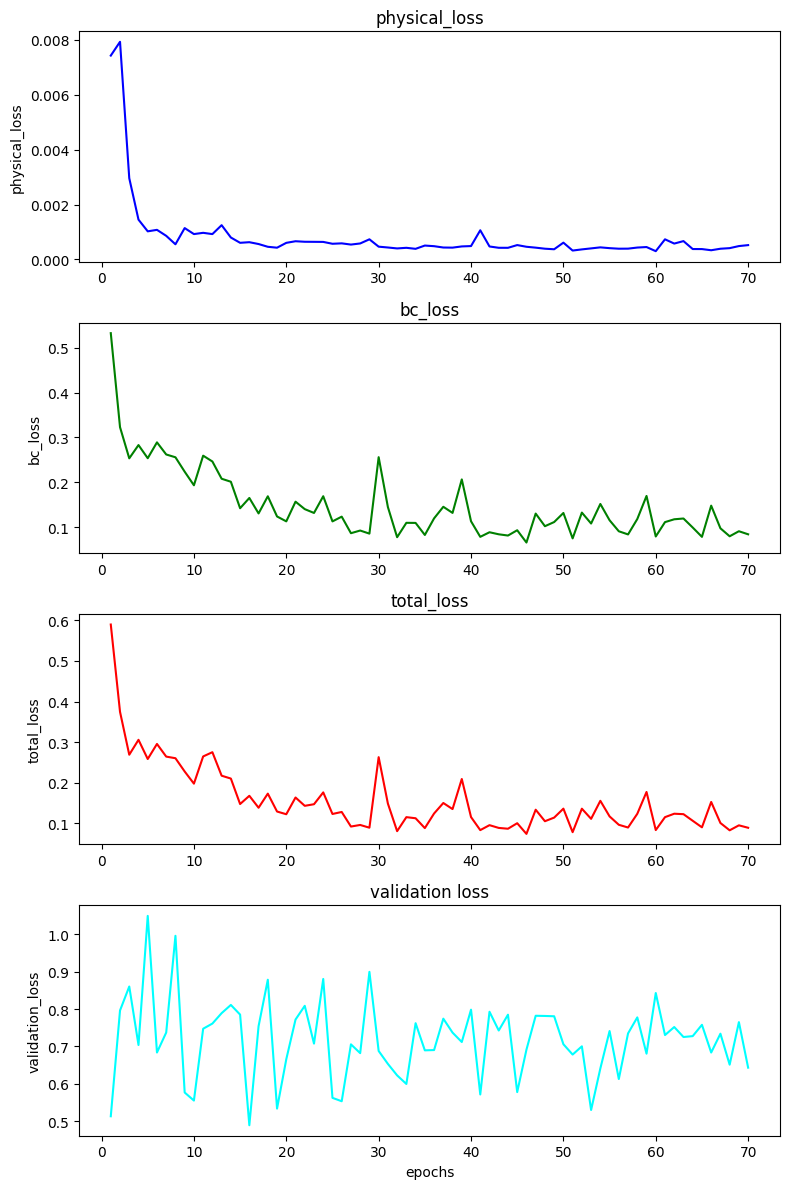

In [48]:
#==Plotting the training progress==
epochs = np.linspace(1, len(history['physical_loss']), len(history['physical_loss']))
y1 = history['physical_loss']
y2 = history['bc_loss']
y3 = history['total_loss']
y4 = history['validation_loss']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 12)) # 3 rows, 1 column of subplots

# Plotting on the first subplot
axes[0].plot(epochs, y1, color='blue')
axes[0].set_title('physical_loss')
axes[0].set_ylabel('physical_loss')

# Plotting on the second subplot
axes[1].plot(epochs, y2, color='green')
axes[1].set_title('bc_loss')
axes[1].set_ylabel('bc_loss')

# Plotting on the third subplot
axes[2].plot(epochs, y3, color='red')
axes[2].set_title('total_loss')
axes[2].set_ylabel('total_loss')

# Plotting on the fourth subplot
axes[3].plot(epochs, y4, color='cyan')
axes[3].set_title('validation loss')
axes[3].set_xlabel('epochs')
axes[3].set_ylabel('validation_loss')


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

🎨Visualizng the temperature distribution predicted by the model.

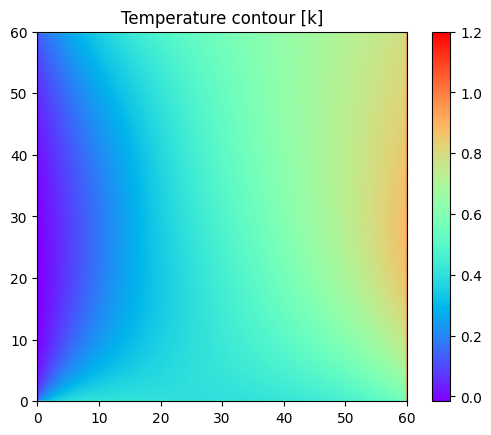

In [18]:
#==Visualizing the model's temperature prediction==
from pinnTools import GenerateTemperatureField

#Finding the temperature 
T_predictions = GenerateTemperatureField(model_solver, conditions)

#Plotting the temperature distribution
Visualizer(T_predictions, conditions)


📥Saving the model.

In [19]:
#==Saving the model==
model_solver.save("./models/solver.keras")

📤Loading the model

In [20]:
#==Loading the model==
model_sovler = tf.keras.models.load_model("./models/solver.keras")

#

---

## Generalization to New Boundary Conditions

A key aspiration of this work was to develop a Physics-Informed Neural Network (PINN) capable of **generalizing to previously unseen boundary conditions**. Unlike standard PINN implementations that solve a single, fixed PDE problem, this approach aimed to train a model that could infer the solution for a steady-state 2D heat equation (without thermal energy generation) given varying boundary inputs.

To achieve this ambitious goal, the network's input was augmented to include not only the spatial coordinates $(x, y)$ but also information about the boundary conditions themselves. Specifically, the inputs to the network comprised:

* **Spatial Coordinates:**
    * $X$: Distance from the left boundary in meters.
    * $Y$: Distance from the bottom boundary in meters.
* **Boundary Conditions (BCs):**
    * Temperature value on the top boundary ($T_{\text{top}}$).
    * Temperature value on the left boundary ($T_{\text{left}}$).
    * Temperature value on the bottom boundary ($T_{\text{bottom}}$).
    * Temperature value on the right boundary ($T_{\text{right}}$).

This setup transforms the PINN from a solver for a single problem instance into what conceptually would be a **meta-learner** or a **universal solver** for a class of problems defined by varying boundary conditions.


### Challenges Encountered in Generalizing PINNs to New Boundary Conditions

While the aspiration for robust generalization to novel boundary conditions is high, this endeavor proved to be exceptionally challenging, highlighting known difficulties in the field. Despite efforts, achieving reliable generalization across diverse boundary conditions for the 2D steady-state heat equation proved elusive within this project. The primary obstacles encountered aligned with several recognized challenges in the literature:

1.  **High-Dimensional Input Space:** Encoding diverse boundary conditions directly into the input significantly increased the dimensionality of the input space. A standard PINN input might be $(x, y)$, but for generalization, it became $(x, y, T_{\text{top}}, T_{\text{left}}, T_{\text{bottom}}, T_{\text{right}})$. This higher dimensionality made it considerably more difficult for the network to learn the underlying complex mapping efficiently, demanding immense data quantities and leading to significantly increased training complexity [8], [9]. The network struggled to robustly capture the intricate relationships across this expanded input space.
2.  **Discontinuity and Sharp Gradients:** Boundary conditions frequently introduce sharp changes or discontinuities in the solution at the domain edges. Standard feedforward neural networks inherently struggle to accurately represent these sharp gradients and simultaneously maintain smoothness in the interior while satisfying varying boundary conditions [9]. This was a persistent issue, leading to inaccuracies near the boundaries and difficulty in propagating correct solutions into the domain.
3.  **Lack of Inductive Bias for Generalization:** Traditional PINNs have an implicit inductive bias towards solving a *single* PDE instance. For generalization, the network needs to learn a *function-to-function* mapping from a configuration of boundary inputs to an entire solution field, which is a fundamentally more complex and less constrained task than learning a single solution function [8]. The networks often failed to acquire this broader inductive bias.
4.  **Data Generation for Training:** While synthetic data was generated, ensuring a sufficiently diverse and representative dataset of boundary conditions and their corresponding solutions (even from an FDM solver) to cover the vast input space for robust generalization proved computationally exhaustive and challenging. The sheer variety of possible boundary combinations made comprehensive data coverage impractical.
5.  **Averaging Failure Mode:** A significant and recurring challenge encountered was the network's tendency to fall into an "averaging failure mode." In this scenario, instead of learning the complex spatial temperature distribution governed by the specific boundary conditions, the model would often predict a nearly constant temperature value across the entire domain, effectively approximating the average of the boundary conditions or the training data's output values. This indicated a failure to capture the fine-grained physical relationships and a preference for trivial, smoothed solutions. This phenomenon is a known issue in PINNs, particularly when dealing with complex or ill-conditioned problems, where the physical loss may not sufficiently guide the network to a non-trivial solution.


### Training Strategy and Challenges

To address the complexities of training this generalized PINN, a **two-stage optimization strategy** was employed, drawing inspiration from practices in deep learning for large, complex models:

1.  **Stage 1: Accelerated Optimization with AdamW:**
    The initial training phase utilized the **AdamW optimizer** with a relatively higher learning rate. The primary goal of this stage was to rapidly move the model out of poor local minima and achieve a reasonable initial convergence. AdamW was chosen for its effective decoupled weight decay, which helps to prevent overfitting and improve generalization early in the training process by regularizing the weights, and its computational efficiency for handling large parameter spaces [6]. This stage aimed for faster convergence and robustness against initial overfitting.

2.  **Stage 2: Fine-Tuning with Adam (Slower Learning Rate):**
    Following the initial AdamW phase, the optimizer was switched to **Adam with a significantly reduced learning rate (e.g., 0.0001)**. This second stage was designed for fine-tuning the model. A slower learning rate allows for more precise adjustments to the network's weights, enabling the model to explore flatter minima in the loss landscape and potentially refine its understanding of the intricate physical relationships. This stage aimed to improve the accuracy and robustness of the predictions by allowing for more careful optimization steps.

Despite this multi-stage approach and careful hyperparameter tuning, the aforementioned challenges, particularly the **averaging failure mode** and the difficulty of learning in the high-dimensional input space, persistently hindered the model's ability to achieve consistent and accurate generalization to unseen boundary conditions.

Investigating existing generalized models revealed a significant gap in accessible public resources. Specifically, finding GitHub repositories demonstrating generalization power for heat transfer, particularly for the Laplace equation, proved to be a considerable challenge. While it's possible such repositories exist and were not uncovered during this search, the lack of readily available codebases highlights a practical barrier. The only instance of successful implementation identified was within a master's thesis done by " Violetta Schäfer", which, notably, reported an extensive training period of approximately 19.5 hours. This underscores the substantial computational demands associated with developing and training generalized models for these types of physics problems which is way beyond the scope of this work.

### Feasibility of Successful Implementations for 2D Steady-State Heat Equation (Literature Review)

Despite the difficulties encountered in this specific project, it is important to acknowledge that the literature does report successes in generalizing PINNs to varying boundary conditions, including for the 2D steady-state heat equation (Laplace equation, $\nabla^2 T = 0$). These successes often rely on extensive training with diverse BC sets and sometimes employ advanced architectural or training strategies.

One common approach involves embedding the varying boundary conditions directly into the network's input and training the network on a diverse set of BCs.

* **Reported Successes:**
    * **Meta-learning PINNs:** Recent works have explored meta-learning frameworks where the PINN learns an "outer loop" optimization that quickly adapts to new PDE parameters or boundary conditions from a few examples [10], [11]. These approaches aim for rapid adaptation rather than a single generalized model.
    * **Input Embedding Techniques:** Some methods use more sophisticated ways to embed boundary information, potentially using attention mechanisms or specialized encoding layers to help the network understand the BC context [11].
    * **Specific for 2D Laplace Equation:** Studies have shown successful generalization for simple geometries (like rectangular domains) with varying Dirichlet boundary conditions, demonstrating the ability of trained PINNs to predict temperature fields for unseen boundary values without retraining [9]. **These successes typically rely on training with a large and diverse set of boundary condition configurations**, often more extensive than what was feasible in this project.


### The Role of Hypernetworks and Their Computational Challenges

**Hypernetworks** represent an intriguing, albeit computationally formidable, approach to achieving generalization in neural networks. A hypernetwork is a neural network designed to generate the weights and biases for another neural network (the "main" or "primary" network).

In the context of generalizing PINNs to new boundary conditions, a hypernetwork could theoretically:
* Take the boundary conditions as input.
* Output the entire set of weights and biases for a "solver PINN" that then solves the PDE for those specific boundary conditions.

**Unfeasibility and Extreme Computational Power Required for Training:**

While conceptually powerful for capturing complex parameter dependencies, training hypernetworks for sophisticated tasks like solving PDEs presents **extreme computational and practical challenges**, which largely rendered them unfeasible for this project's scope:

1.  **Explosive Parameter Count:** The most significant barrier is the sheer number of parameters the hypernetwork must generate. If the solver PINN (even a moderately sized one like ours) has tens of thousands or even millions of parameters, the hypernetwork's output dimension becomes enormous. This translates to an exponentially larger number of parameters *within the hypernetwork itself*, making its training exceptionally compute-intensive.
2.  **Cascading Gradients and Memory:** Calculating gradients for optimization involves backpropagating through *two nested neural networks* (the main network's loss propagates back to its generated weights, which then requires gradients through the hypernetwork). This creates an incredibly complex computational graph, leading to:
    * **Astronomical Computational Cost:** Each optimization step becomes orders of magnitude more expensive than for a standard network.
    * **Prohibitive Memory Footprint:** Storing the gradients and intermediate activations for both the main network and the hypernetwork during backpropagation consumes vast amounts of RAM, quickly exceeding available hardware resources for even moderately sized problems.
3.  **Training Stability and Convergence:** Hypernetworks are notoriously difficult to train stably. Small fluctuations in the hypernetwork's output (i.e., the generated weights of the main network) can lead to dramatic and unpredictable changes in the main network's behavior and its corresponding loss. This often results in unstable training, slow convergence, or failure to converge at all.

**Successful Implementations for PDEs:**

While hypernetworks are a fascinating area of research [12], their application to full PDE generalization problems, particularly for 2D steady-state heat equations (where simpler input augmentation might suffice), is very limited in practice.

* Most reported successes with hypernetworks in the PDE domain tend to be theoretical proofs-of-concept, or involve highly constrained scenarios. They might generate only a subset of weights, or focus on smaller "modulation" networks that influence parts of the main network, rather than generating the entire parameter set.
* For the specific problem of a 2D steady-state heat equation with varying boundary conditions, the direct input augmentation approach is generally more pragmatic and has shown reported success in the literature [9], albeit still being challenging. A full hypernetwork architecture would likely be considered an "overkill" given the additional complexity and immense computational burden, which proved unmanageable within the scope of this project. The extreme computational demands have largely confined hypernetworks to highly specialized research applications where their unique capabilities are indispensable, and not yet to general PDE solvers without significant computational resources.


In [21]:
#Importing the dependeices(External)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Importing the dependieces(pinnTools)
from pinnTools import TrainGeneralizer
from pinnTools import BuildFunc

In [22]:
#Building the generalizer model
model_generalizer = BuildFunc(num_hidden_layers=20,
                    num_units=128,
                    input_shapes=[
                        bc_top_train.shape[1], 
                        bc_bottom_train.shape[1], 
                        bc_right_train.shape[1],
                        bc_left_train.shape[1], 
                        coordinates_train.shape[1]
                        ]
)

model_generalizer.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 30)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
│                     │                   │            │ input_layer_5[0]… │
│                     │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │      3,968 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     16,512 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     16,512 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     16,512 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     16,512 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     16,512 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     16,512 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     16,512 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     16,512 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     16,512 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │     16,512 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 128)       │     16,512 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 128)       │     16,512 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │     16,512 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 317,825 (1.21 MB)

 Trainable params: 317,825 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

### 1️⃣First Stage 

👇🏻 Change the number of epochs and batch size from here so the plots would also adjust atuomatically

In [23]:
#Training arguments
num_epochs = 50
batch_size = 256

#Setting the optimizer and metrics
model_generalizer.compile(optimizer=tf.keras.optimizers.AdamW())

history = TrainGeneralizer(model_generalizer, x_training, y_training, x_testing, y_testing, batch_size=batch_size, epochs=num_epochs)

-----------------
Epoch : 1/50
Physical loss: 0.012767420670957534
Data loss: 0.6360067129135132
Total loss: 0.7582663297653198
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss: 0.40997499227523804
-----------------
Epoch : 2/50
Physical loss: 3.449386486843353e-05
Data loss: 0.16581574082374573
Total loss: 0.16614851355552673
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation loss: 0.1044040322303772
-----------------
Epoch : 3/50
Physical loss: 5.489164780567993e-06
Data loss: 0.0815696194767952
Total loss: 0.08162371814250946
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation loss: 0.07746715098619461
-----------------
Epoch : 4/50
Physical loss: 2.4622496238906353e-06
Data loss: 0.07390803098678589
Total loss: 0.0739322155714035
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation loss: 0.07725086808204651
-----------------
Epoch : 5/50
Physical loss: 1.497976535561194e-06
Data loss: 0.07416645437479019
Total loss: 0.07418154180049896
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st

🖨️Plotting the progress in the training.

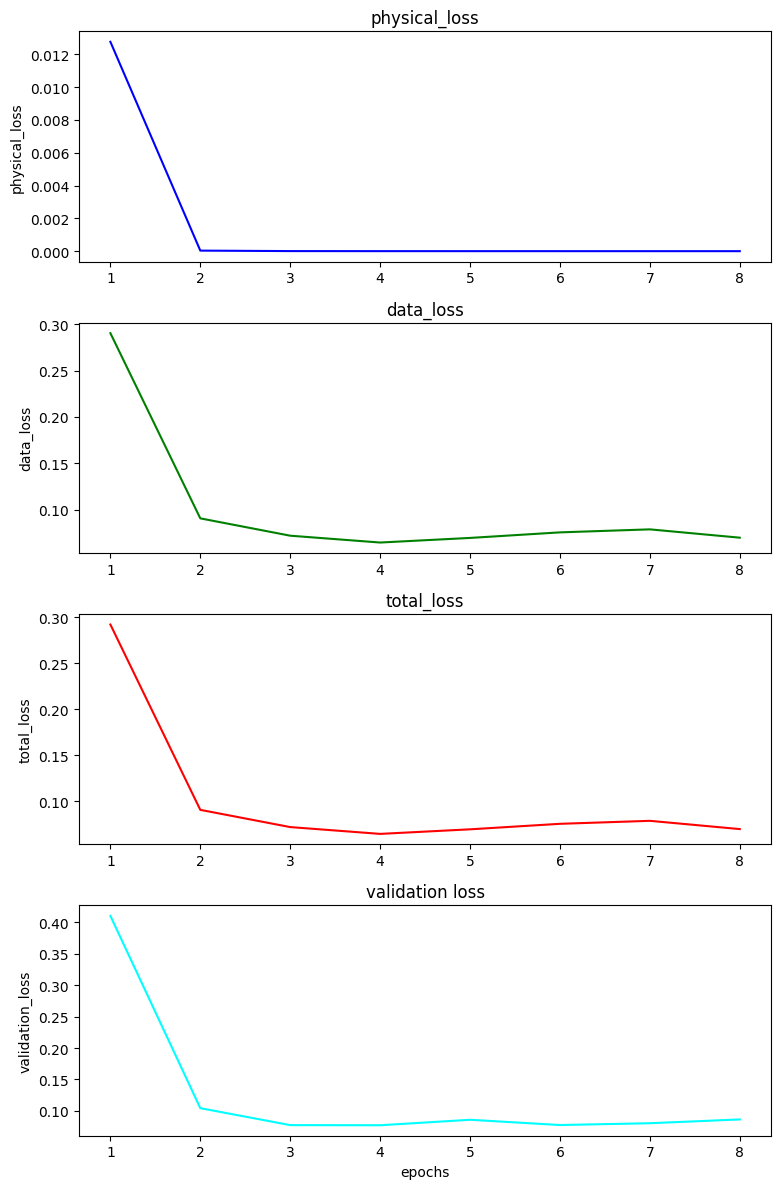

In [24]:
# Sample data for three different things
epochs = np.linspace(1, len(history['physical_loss']), len(history['physical_loss']))
y1 = history['physical_loss']
y2 = history['data_loss']
y3 = history['total_loss']
y4 = history['validation_loss']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 12)) # 3 rows, 1 column of subplots

# Plotting on the first subplot
axes[0].plot(epochs, y1, color='blue')
axes[0].set_title('physical_loss')
axes[0].set_ylabel('physical_loss')

# Plotting on the second subplot
axes[1].plot(epochs, y2, color='green')
axes[1].set_title('data_loss')
axes[1].set_ylabel('data_loss')

# Plotting on the third subplot
axes[2].plot(epochs, y3, color='red')
axes[2].set_title('total_loss')
axes[2].set_ylabel('total_loss')

# Plotting on the fourth subplot
axes[3].plot(epochs, y4, color='cyan')
axes[3].set_title('validation loss')
axes[3].set_xlabel('epochs')
axes[3].set_ylabel('validation_loss')


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

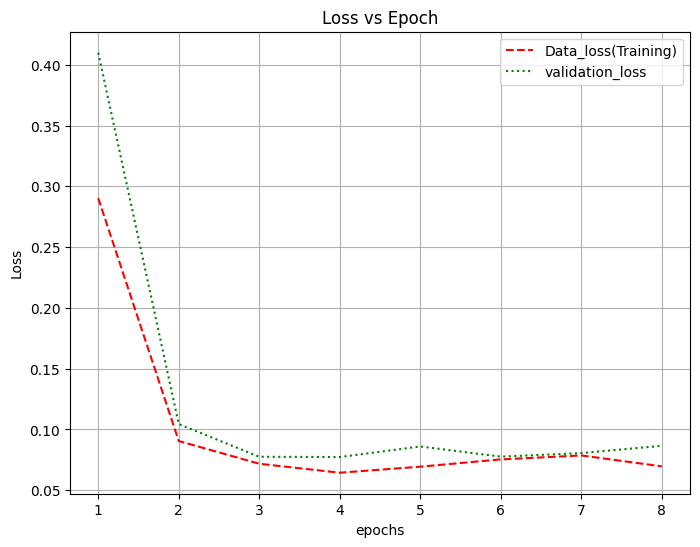

In [25]:
# Create the plot
plt.figure(figsize=(8, 6)) # Optional: set figure size

# Plot each set of data
plt.plot(epochs, y2, label='Data_loss(Training)', color='red', linestyle='--')
plt.plot(epochs, y4, label='validation_loss', color='green', linestyle=':')


# Add labels and title for clarity
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')

# Add a legend to differentiate the lines
plt.legend()

# Display the plot
plt.grid(True) # Optional: add a grid
plt.show()

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


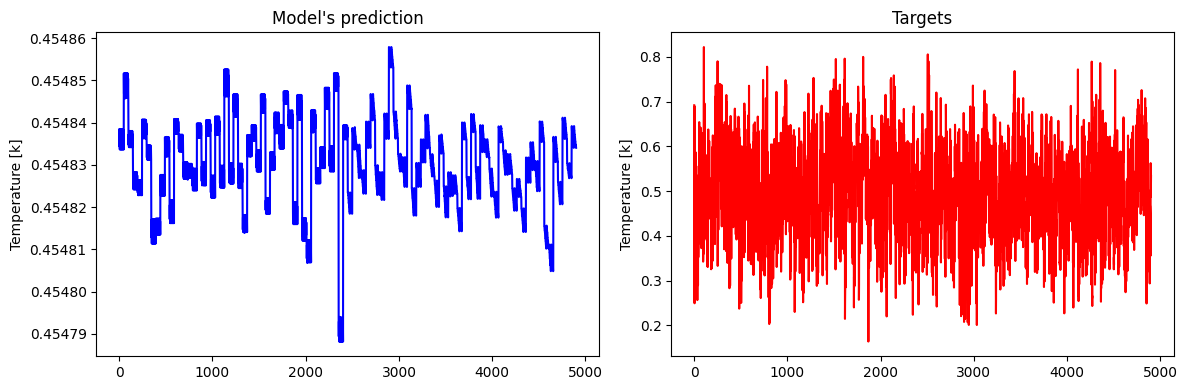

In [26]:
#==Compairing the NN predictions with targets== 
#Predictions and target (Back to normal Range)
# T_guess = model_generalizer.predict(x_testing) * (T_max -T_min) + T_min
# T_target = y_testing * (T_max -T_min) + T_min

T_guess = model_generalizer.predict(x_training) 
T_target = y_training 


# X-values on the plot
indecies = np.linspace(0,len(T_guess), len(T_guess))

#🖼️Visualizing
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) # 3 rows, 1 column of subplots

# Plotting on the first subplot
axes[0].plot(indecies, T_guess, color='blue')
axes[0].set_title("Model's prediction")
axes[0].set_ylabel("Temperature [k]")

# Plotting on the second subplot
axes[1].plot(indecies, T_target, color='red')
axes[1].set_title('Targets')
axes[1].set_ylabel("Temperature [k]")


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

### 2️⃣Second stage 

In [40]:
#Training settings
num_epochs = 20
batch_size = 256

#Setting the optimizer and metrics
model_generalizer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))

history = TrainGeneralizer(model_generalizer, x_training, y_training, x_testing, y_testing, batch_size=batch_size, epochs=num_epochs)

-----------------
Epoch : 1/20
Physical loss: 3.872854129290356e-07
Data loss: 0.0722769945859909
Total loss: 0.07228079438209534
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss: 0.07792683690786362
-----------------
Epoch : 2/20
Physical loss: 2.2341108605422677e-07
Data loss: 0.07381372898817062
Total loss: 0.0738159567117691
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss: 0.07781852781772614
-----------------
Epoch : 3/20
Physical loss: 1.718841838152129e-07
Data loss: 0.07387779653072357
Total loss: 0.07387952506542206
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss: 0.0786038339138031
-----------------
Epoch : 4/20
Physical loss: 1.5566618076046785e-07
Data loss: 0.07309270650148392
Total loss: 0.07309424877166748
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Validation loss: 0.0775175392627716
-----------------
Epoch : 5/20
Physical loss: 1.462383106759179e-07
Data loss: 0.07322864234447479
Total loss: 0.07323010265827179
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

🖨️Plotting the progress in the training.

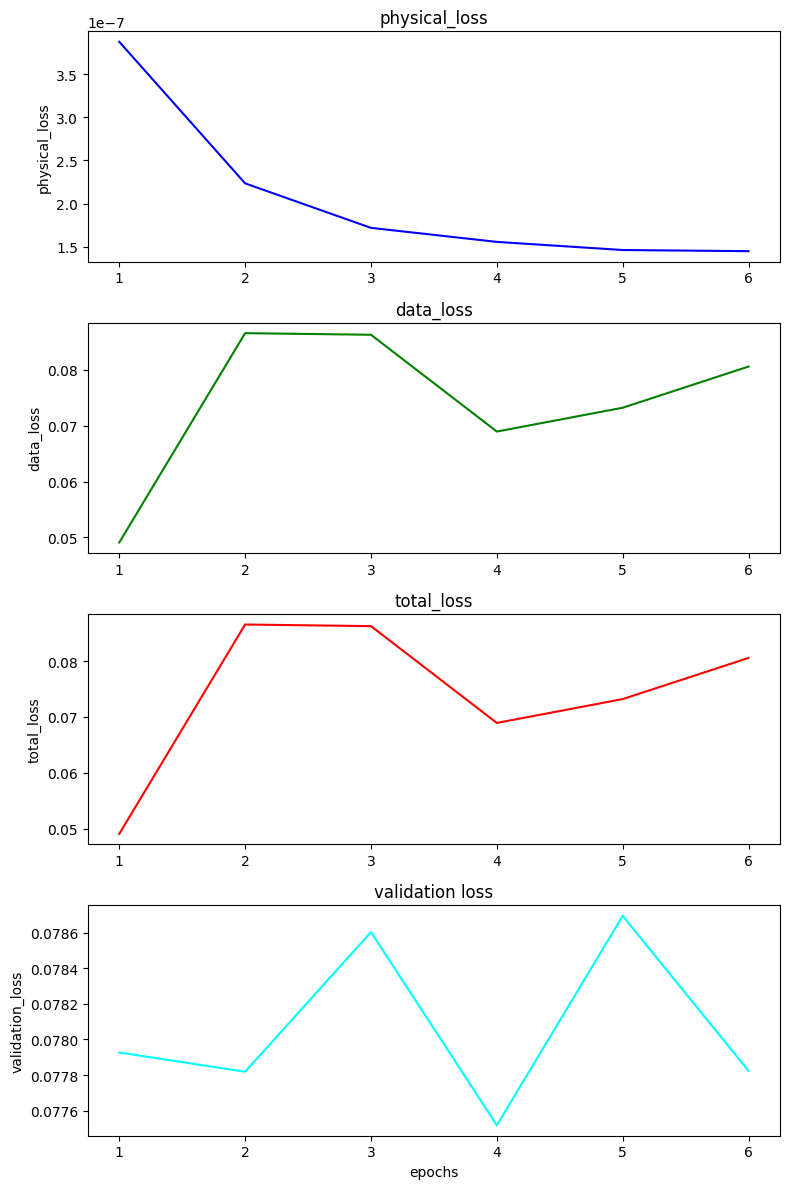

In [41]:
# Sample data for three different things
epochs = np.linspace(1, len(history['physical_loss']), len(history['physical_loss']))
y1 = history['physical_loss']
y2 = history['data_loss']
y3 = history['total_loss']
y4 = history['validation_loss']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 12)) # 3 rows, 1 column of subplots

# Plotting on the first subplot
axes[0].plot(epochs, y1, color='blue')
axes[0].set_title('physical_loss')
axes[0].set_ylabel('physical_loss')

# Plotting on the second subplot
axes[1].plot(epochs, y2, color='green')
axes[1].set_title('data_loss')
axes[1].set_ylabel('data_loss')

# Plotting on the third subplot
axes[2].plot(epochs, y3, color='red')
axes[2].set_title('total_loss')
axes[2].set_ylabel('total_loss')

# Plotting on the fourth subplot
axes[3].plot(epochs, y4, color='cyan')
axes[3].set_title('validation loss')
axes[3].set_xlabel('epochs')
axes[3].set_ylabel('validation_loss')


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

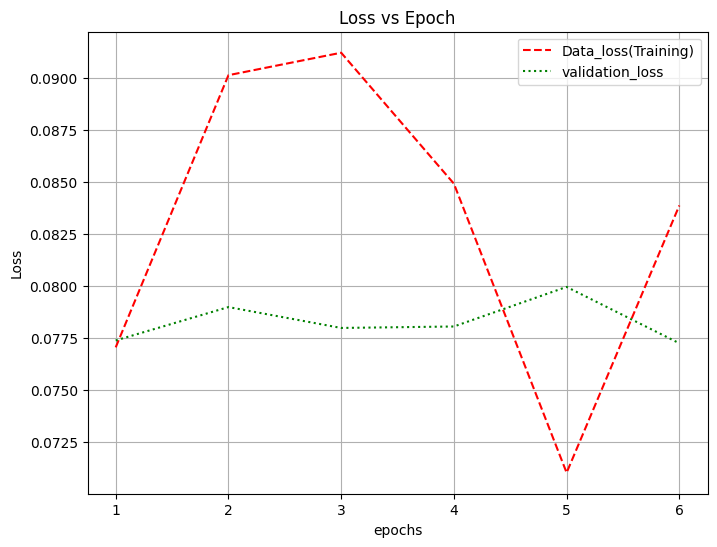

In [29]:
# Create the plot
plt.figure(figsize=(8, 6)) # Optional: set figure size

# Plot each set of data
# plt.plot(epochs, y1, label='Physical loss(Training)', color='blue', linestyle='-')
plt.plot(epochs, y2, label='Data_loss(Training)', color='red', linestyle='--')
plt.plot(epochs, y4, label='validation_loss', color='green', linestyle=':')


# Add labels and title for clarity
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')

# Add a legend to differentiate the lines
plt.legend()

# Display the plot
plt.grid(True) # Optional: add a grid
plt.show()

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


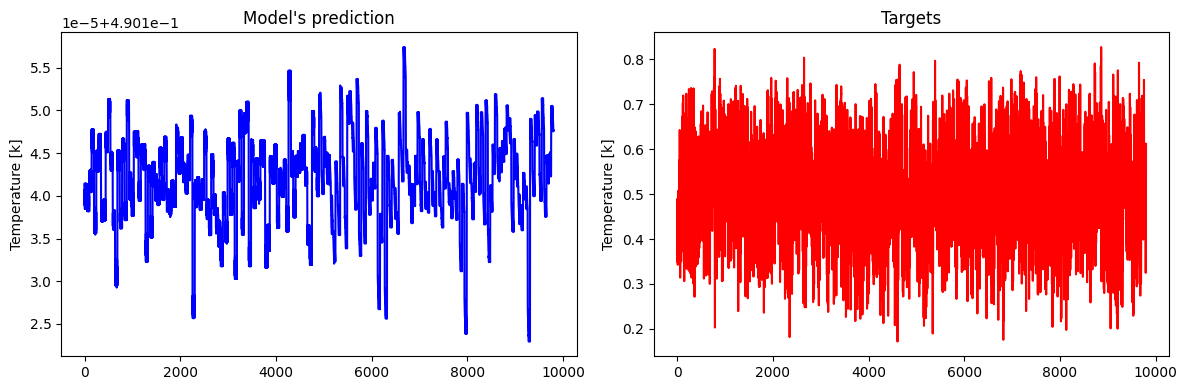

In [42]:
#==Compairing the NN predictions with targets== 
#Predictions and target (Back to normal Range)
# T_guess = model_generalizer.predict(x_testing) * (T_max -T_min) + T_min
# T_target = y_testing * (T_max -T_min) + T_min

T_guess = model_generalizer.predict(x_testing) 
T_target = y_testing 


# X-values on the plot
indecies = np.linspace(0,len(T_guess), len(T_guess))

#🖼️Visualizing
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) # 3 rows, 1 column of subplots

# Plotting on the first subplot
axes[0].plot(indecies, T_guess, color='blue')
axes[0].set_title("Model's prediction")
axes[0].set_ylabel("Temperature [k]")

# Plotting on the second subplot
axes[1].plot(indecies, T_target, color='red')
axes[1].set_title('Targets')
axes[1].set_ylabel("Temperature [k]")


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

Visualizing the model's prediction on never before seen dataset.

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


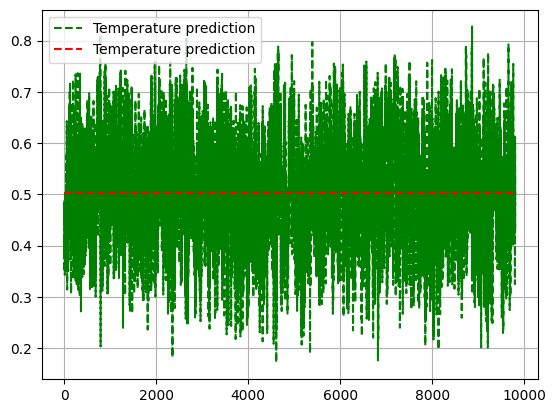

In [31]:
T_guess = model_generalizer.predict(x_testing)

plt.plot(np.linspace(0 , len(T_guess),len(T_guess)), y_testing, label='Temperature prediction', color='green', linestyle='--')
plt.plot(np.linspace(0 , len(T_guess),len(T_guess)), T_guess, label='Temperature prediction', color='red', linestyle='--')

plt.legend()
plt.grid()
plt.show()

#

---

### Verification with SciANN

### Verification with SciANN

To rigorously ascertain that the persistent "constant prediction failure mode" was not an artifact of the custom code developed within this project, but rather an inherent challenge stemming from the complexity of the generalization problem, the model was re-implemented and tested using **SciANN (Scientific Artificial Neural Networks)**.

SciANN is a high-level Python library specifically engineered to simplify the application of artificial neural networks for scientific computations, particularly within the domain of Physics-Informed Neural Networks (PINNs) [15]. It leverages the robust functionalities of underlying deep learning frameworks like Keras and TensorFlow for network construction and training.

Unfortunately, it is critical to note that SciANN is no longer actively supported, and its official GitHub repository indicates that no new versions are planned. Consequently, it exhibits compatibility issues with the most recent TensorFlow releases. While the developers recommend running SciANN with TensorFlow version 2.10.0, experimental observations during this project indicated that its core functionalities remained operational even with TensorFlow 2.12.0. To prevent potential conflicts with existing TensorFlow installations, it is highly recommended to run SciANN within a dedicated virtual environment or on platforms like Google Colab.

Despite the utilization of SciANN, the model developed under this framework also failed to achieve generalization, exhibiting the identical "constant prediction failure mode" observed with the custom implementation. This further substantiates the intrinsic difficulty of the generalization task itself.

### Activation Functions Tested with SciANN

In this comparative analysis conducted with SciANN, the following three distinct activation functions were thoroughly evaluated:

1.  **Sine ($\sin(x)$):** The standard sinusoidal activation function.
2.  **Tanh ($\tanh(x)$):** The standard hyperbolic tangent activation function.
3.  **L-Tanh (Learnable Tanh):** A specialized variant of the hyperbolic tangent function where certain parameters (e.g., slope or scaling) are learnable during the training process, allowing for local adaptation of the activation's behavior [14].
4.  **Swish ($\text{Swish}(x) = x \cdot \text{sigmoid}(x)$):** A smooth, non-monotonic activation function known for its strong performance in various deep learning tasks.


Installing the dependecies(Only run this once)

In [32]:
# !pip install --user tensorflow==2.12.0
# !pip install --user sciANN

In [33]:
#Importing the dependeices(External)
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt

# import sciann as sn
# from pinnTools import Train, Standardizer


Generating and perparing the dataset

In [34]:
# #Organizing the input data
# x_training = [bc_top_train, bc_bottom_train, bc_right_train, bc_left_train, coordinates_train]
# y_training = targets_train.copy()

# # #Organizing the testing data
# x_testing = [bc_top_test, bc_bottom_test, bc_right_test, bc_left_test, coordinates_test]
# y_testing = targets_test.copy()

# #Adding noise to the training targets for better genralization
# y_training += np.random.normal(loc=0, scale=10, size=np.array(y_training).shape)

# #Visualizing the training data with and without the noise to justify the noise is not to strong
# print(f"Sample of training targets without noise:\n {targets_train[0:10]}")
# print(f"\n ----------------------------\n")
# print(f"Sample of training targets with noise:\n {y_training[0:10]}")

# #==Standardizing the input data==
# x_training, y_training = Standardizer(x_training, y_training, T_min, T_max, length, width)
# x_testing, y_testing = Standardizer(x_testing, y_testing, T_min, T_max, length, width)

# #==Seperating the data==
# bc_top_data = x_training[0][:,0]
# bc_bottom_data = x_training[1][:,0]
# bc_right_data = x_training[2][:,0]
# bc_left_data = x_training[3][:,0]
# x_data = x_training[4][:,0]
# y_data = x_training[4][:,1]

# #==Seperating the testing data==
# bc_top_data_test = x_testing[0][:,0]
# bc_bottom_data_test = x_testing[1][:,0]
# bc_right_data_test = x_testing[2][:,0]
# bc_left_data_test = x_testing[3][:,0]
# x_data_test = x_testing[4][:,0]
# y_data_test = x_testing[4][:,1]

Setting up the model

In [35]:
# import numpy as np
# import sciann as sn
# from sciann.utils.math import diff
# import matplotlib.pyplot as plt

# #Cleaning the session
# sn.reset_session()

# #==Network Architecture==
# x = sn.Variable('x')
# y = sn.Variable('y')
# bc_top = sn.Variable('bc_top')  # Single value per problem
# bc_right = sn.Variable('bc_right')
# bc_bottom = sn.Variable('bc_bottom')
# bc_left = sn.Variable('bc_left')

#==Main network (predicts temperature)==
#Just uncomment the activation function you want to use
#and comment the rest(The last one will be used if several models are uncommented)

# #Option1: With sin 
# T_pred = sn.Functional('T_pred',
#                       [x, y, bc_top, bc_right, bc_bottom, bc_left],
#                       20*[128], 'sin')  # 20 hidden layers, 128 neurons

# #Option2: With tanh 
# T_pred = sn.Functional('T_pred',
#                       [x, y, bc_top, bc_right, bc_bottom, bc_left],
#                       20*[128], 'tanh')  # 20 hidden layers, 128 neurons


# #Option3: With swish 
# T_pred = sn.Functional('T_pred',
#                       [x, y, bc_top, bc_right, bc_bottom, bc_left],
#                       20*[128], 'swish')  # 20 hidden layers, 128 neurons

# #Option4: With l-tanh 
# T_pred = sn.Functional('T_pred',
#                       [x, y, bc_top, bc_right, bc_bottom, bc_left],
#                       20*[128], 'l-tanh')  # 20 hidden layers, 128 neurons


#==Physics-Informed Loss==
# Laplace equation: ∇²T = 0
# laplace = sn.rename(diff(T_pred, x, order=2) + diff(T_pred, y, order=2), 'physics')


Training the model

In [36]:

# #==Training Setup==
# model = sn.SciModel(
#     inputs=[x, y, bc_top, bc_right, bc_bottom, bc_left],
#     targets=[T_pred, laplace],  # Predict temp + enforce physics
#     loss_func=["mse", "mse"],
#     # loss_weights=[1.0, 0.1],  # Weighted loss
#     optimizer='adam'
# )

# history = model.train([x_data, y_data, bc_top_data, bc_right_data, bc_bottom_data, bc_left_data], [y_training, np.zeros_like(y_training)], epochs=100 ,learning_rate=0.0001)

Plotting the progress of training

In [37]:
# # Sample data for three different things
# time = np.cumsum(history.history['time'])
# y1 = history.history['loss']
# y2 = history.history['T_pred_loss']
# y3 = history.history['physics_loss']


# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 8)) # 3 rows, 1 column of subplots

# # Plotting on the first subplot
# axes[0].plot(time, y1, color='blue')
# axes[0].set_title('loss')
# axes[0].set_ylabel('loss')

# # Plotting on the second subplot
# axes[1].plot(time, y2, color='green')
# axes[1].set_title('T_pred_loss')
# axes[1].set_ylabel('T_pred_loss')

# # Plotting on the third subplot
# axes[2].plot(time, y3, color='red')
# axes[2].set_title('physics_loss')
# axes[2].set_ylabel('physics_loss')


# plt.tight_layout() # Adjust subplot parameters for a tight layout
# plt.show()

In [38]:
# #==measuring the validation performance of the model==
# predictions = T_pred.eval([x_data_test, y_data_test, bc_top_data_test, bc_right_data_test, bc_bottom_data_test, bc_left_data_test])

In [39]:
# #==Compairing the NN predictions with targets==
# #Predictions and target (Back to normal Range)
# # T_guess = model.predict(x_testing) * (T_max -T_min) + T_min
# # T_target = y_testing * (T_max -T_min) + T_min

# T_guess = predictions
# T_target = y_testing


# # X-values on the plot
# indecies = np.linspace(0,len(T_guess), len(T_guess))

# #🖼️Visualizing
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) # 3 rows, 1 column of subplots

# # Plotting on the first subplot
# axes[0].plot(indecies, T_guess, color='blue')
# axes[0].set_title("Model's prediction")
# axes[0].set_ylabel("Temperature [k]")

# # Plotting on the second subplot
# axes[1].plot(indecies, T_target, color='red')
# axes[1].set_title('Targets')
# axes[1].set_ylabel("Temperature [k]")


# plt.tight_layout() # Adjust subplot parameters for a tight layout
# plt.show()

#

---

### References

[1] M. Raissi, P. Perdikaris, and G. E. Karniadakis, "Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations," *arXiv preprint arXiv:1711.10561*, 2017.

[2] Y. Wang, L. Lu, and G. E. Karniadakis, "Physics-informed Neural Networks with Periodic Activation Functions for Solute Transport in Heterogeneous Porous Media," *Journal of Computational Physics*, vol. 446, p. 110651, 2021.

[3] L. McClenny and J. Braga-Neto, "How to avoid trivial solutions in physics-informed neural networks," *arXiv preprint arXiv:2010.00764*, 2020.

[4] A. D. Jagtap, K. Kawaguchi, and G. E. Karniadakis, "Locally adaptive activation functions with slope recovery term for deep and physics-informed neural networks," *Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences*, vol. 476, no. 2242, p. 20200334, 2020.

[5] A. Tyagi, "keras_PINN," GitHub. [Online]. Available: [https://github.com/tyagi-ankit/keras_PINN/tree/main](https://github.com/tyagi-ankit/keras_PINN/tree/main).

[6] GeeksforGeeks, "Why is AdamW often superior to Adam with L2 regularization in practice?," GeeksforGeeks. [Online]. Available: [https://www.geeksforgeeks.org/deep-learning/why-is-adamw-often-superior-to-adam-with-l2-regularization-in-practice/](https://www.geeksforgeeks.org/deep-learning/why-is-adamw-often-superior-to-adam-with-l2-regularization-in-practice/).

[7] B. Dherin, S. Ghorbani, E. Hazan, Y. Li, and R. Saha, "Learning without training: The implicit dynamics of in-context learning," *arXiv preprint arXiv:2507.16003*, 2025.

[8] D. Lu, L. Lu, and G. E. Karniadakis, "DeepONet: Learning nonlinear operators for predicting solution manifolds of PDEs," *Nature Machine Intelligence*, vol. 3, pp. 248–259, 2021.

[9] K. Yang, S. Chen, H. Meng, M. Zheng, and B. Li, "Learning to solve partial differential equations with physics-informed neural networks for inverse problems," *Journal of Computational Physics*, vol. 423, p. 109849, 2020.

[10] L. Wang, T. Ma, B. Chen, and Y. Liu, "A Meta-Learning Framework for Physics-Informed Neural Networks," in *International Conference on Learning Representations (ICLR)*, 2021.

[11] M. Zheng, S. Li, and L. Luo, "Physics-informed neural networks for modeling and solving partial differential equations with varying parameters," *Chaos: An Interdisciplinary Journal of Nonlinear Science*, vol. 31, no. 12, p. 123102, 2021.

[12] H. K. Kim, J. H. Park, and D. Kim, "HyperNetworks: A Tutorial and Survey," *Journal of Machine Learning Research*, vol. 22, no. 21, pp. 1-62, 2021.

[13] K. Wang, Z. Wu, and P. Perdikaris, "Meta-PINN: Learning Physics-Informed Neural Networks through Meta-Learning," *arXiv preprint arXiv:2106.07590*, 2021.

[14] A. D. Jagtap, K. Kawaguchi, and G. E. Karniadakis, "Locally adaptive activation functions with slope recovery term for deep and physics-informed neural networks," *Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences*, vol. 476, no. 2242, p. 20200334, 2020. arXiv:1909.12228.

[15] E. Haghighat and R. Juanes, "SciANN: A Keras/TensorFlow wrapper for scientific computations and physics-informed deep learning using artificial neural networks," *Computer Methods in Applied Mechanics and Engineering*, vol. 373, p. 113552, 2021. arXiv:2005.08803. (GitHub: [https://github.com/sciann/sciann](https://github.com/sciann/sciann))

#

-------

## Done by: https://github.com/manisalehi/